In [5]:
### packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import datetime
import time
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gaussian_kde

In [6]:
### Read CSV data
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 1, 1)
numberofdates=start-end
print(numberofdates)
stocks = '000001.SS'
SSE = yf.download(stocks,start=start, end=end, interval='1d')
SSE.head()

-4748 days, 0:00:00


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,3289.750000,3295.279053,3243.319092,3243.760010,3243.760010,109400
2010-01-05,3254.468018,3290.511963,3221.461914,3282.178955,3282.178955,126200
2010-01-06,3277.517090,3295.867920,3253.043945,3254.215088,3254.215088,123600
2010-01-07,3253.990967,3268.819092,3176.707031,3192.775879,3192.775879,128600
2010-01-08,3177.259033,3198.919922,3149.017090,3195.997070,3195.997070,98400


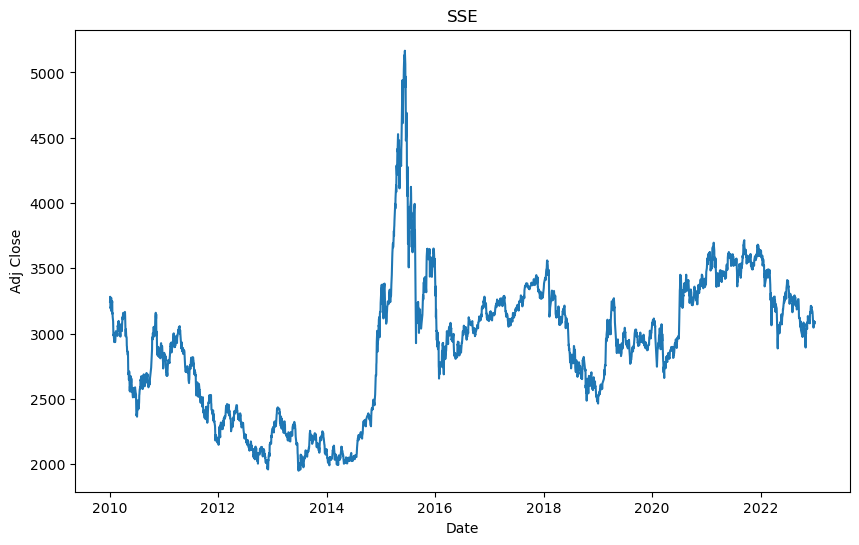

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(SSE.index,SSE['Adj Close'])
plt.title('SSE')
plt.ylabel('Adj Close')
plt.xlabel('Date')
plt.show()

In [8]:
### p-value &ADF test
print("p-value:%f" % adfuller(SSE["Adj Close"])[1])

p-value:0.152294


As the p-value is greater than level of significance, we fail to reject the null that a unit root is present in this time series.

In [9]:
returns = 100* SSE["Adj Close"].pct_change().dropna()

In [ ]:
#graph returns
realized_vol = returns.rolling(5).std().dropna()
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- SSE')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

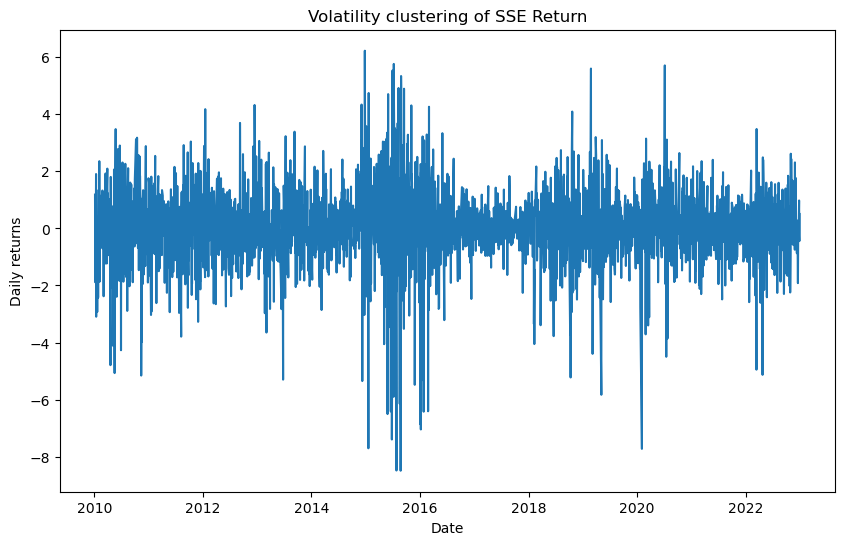

In [11]:
#graph volatility
plt.figure(figsize=(10, 6))
plt.plot(SSE.index[1:],returns)
plt.title('Volatility clustering of SSE Return')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.show()

In [12]:
amp1 = arch_model(returns,vol="ARCH",p=1)
resp1 = amp1.fit()
print(resp1summary())
forecastp1 = resp1.forecast()
print(forecastp1)

amp2 = arch_model(returns,vol="ARCH",p=2)
resp2 = amp1.fit()
print(resp2.summary())
forecastp2 = resp2.forecast()
print(forecastp2)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13260.561204604102
Iteration:      2,   Func. Count:     13,   Neg. LLF: 5594.960205738018
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6316.337592118463
Iteration:      4,   Func. Count:     25,   Neg. LLF: 5195.247960536689
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5195.24795974189
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5195.24795974189
            Iterations: 5
            Function evaluations: 29
            Gradient evaluations: 5


NameError: name 'resp1summary' is not defined

In [ ]:
# Select the best arch model
n = 4748
split_date = returns.iloc[-n:].index

bic_arch = []
for p in range(1, 3):
        arch = arch_model(returns, mean='zero',vol='ARCH', p=p)\
            .fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param_arch = p
arch = arch_model(returns, mean='zero', vol='ARCH',p=best_param_arch)\
            .fit(disp='off')
print(arch.summary())
forecast_arch = arch.forecast(start=split_date[0])
print(forecast_arch)

In [ ]:
# Select the best garch model
bic_garch = []
for p in range(1, 3):
    for q in range(1, 3):
        garch = arch_model(returns, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param_garch = p, q
garch = arch_model(returns, mean='zero', vol='GARCH',p=best_param_garch[0], o=0, q=best_param_garch[1])\
            .fit(disp='off')
print(garch.summary())
forecast_garch = garch.forecast(start=split_date[0])
print(forecast_garch)

The best model selected is ARCH(2) and GARCH(1,1). Using AIC and BIC as our model selection criterion, GARCH(1,1) seems to be a even better model as it minimize aic and bic.

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,
                  label='Volatility Prediction ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()

NameError: name 'forecast_garch' is not defined

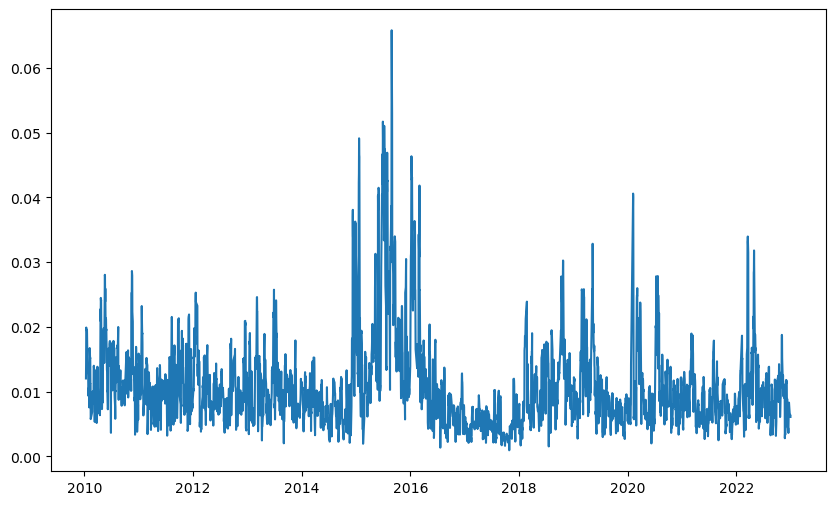

In [13]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100,
                  label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()

By visual inspection we could tell the garch model is more appropriate for predicting the 

# Tree ensemble

We will first use tree ensemble model to evaluate the volatility of the SSE. We use returns in this model, and save the last 180 days as the test data to represent how this model is capable of making predictions.

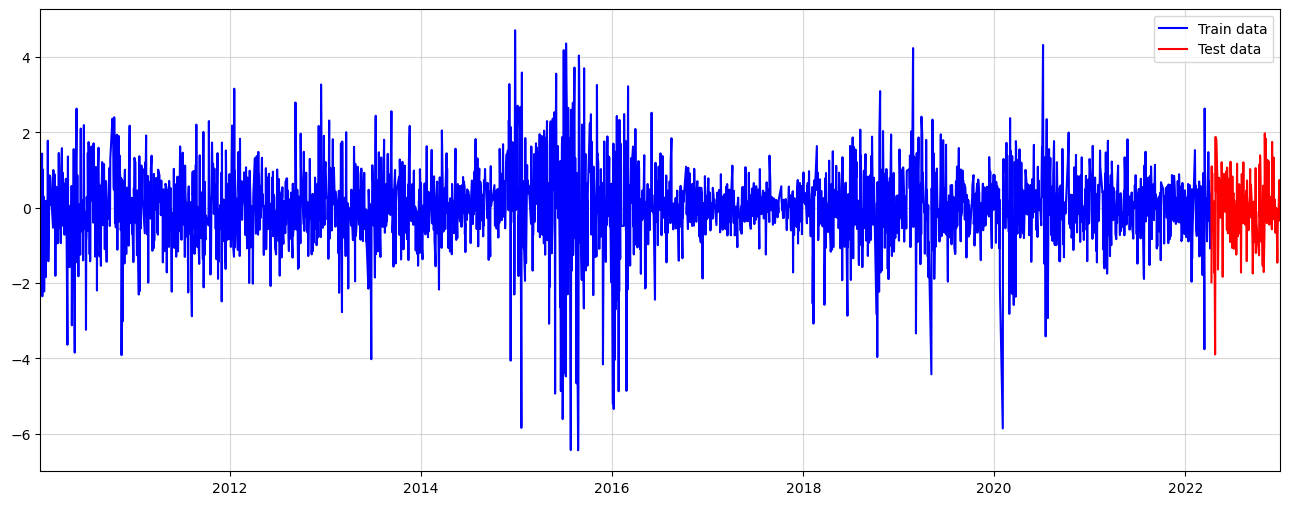

In [68]:
n_test = 180
train = returns.iloc[:-n_test]
train_mean = train.mean()
train_std = train.std()
train = (train-train_mean)/train_std
test = returns.iloc[-n_test:]
test = (test-train_mean)/train_std #be careful to spill information over into the test period
plt.figure(figsize = (16,6))
plt.plot(train, color = "blue", label = "Train data")
plt.plot(test, color = "red", label = "Test data")
plt.grid(alpha = 0.5)
plt.margins(x=0)
plt.legend()

# Random Forest Model

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Combine returns and realized volatility into a DataFrame, we dropna so we start in 2011 01 11
data = pd.DataFrame({'returns': returns, 'realized_vol': realized_vol}).dropna()

# Reshape 'returns' to a 2D array
X = data['returns'].values.reshape(-1, 1)  # Features
y = data['realized_vol']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Predict the volatility on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Optionally, you can also print feature importances
feature_importances = rf_regressor.feature_importances_
print("Feature Importances:", feature_importances)

Mean Squared Error: 0.46362544887785423
Feature Importances: [1.]


In [70]:

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
 
 Check for and handle categorical variables
label_encoder = LabelEncoder()
x_categorical = df.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = df.select_dtypes(exclude=['object']).values
x = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values
 
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
 
# Fit the regressor with x and y data
regressor.fit(x, y)

IndentationError: unexpected indent (4037918672.py, line 5)

# SVM-GARCH

In [18]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from arch import arch_model

# Assuming 'SSE' DataFrame with 'Adj Close' and 'Volume'
# Calculate daily returns
returns = SSE['Adj Close'].pct_change().dropna()

# Create lagged features for returns and other indicators like volume
lags = 5
for i in range(1, lags + 1):
    SSE[f'return_lag_{i}'] = returns.shift(i)
SSE['Volume_lagged'] = SSE['Volume'].shift(1)

# Ensure all lagged features are aligned and remove rows with NaN values
SSE_clean = SSE.dropna()

# Prepare features and the target variable from the cleaned DataFrame
features = SSE_clean.iloc[:, 1:]  # Assuming 'Adj Close' is the first column and we skip it for features
target = SSE_clean['Adj Close'].pct_change().iloc[1:]  # Target variable recalculated to align, dropping first NaN

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.iloc[:-1, :])  # Align features by removing the last row to match target's length

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

# SVM Model Optimization
svm_model = SVR(kernel='rbf')
param_grid = {'C': [1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1], 'epsilon': [0.01, 0.1, 1]}
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
optimized_svm = grid_search.best_estimator_

# Forecast returns using optimized SVM model
predicted_returns = optimized_svm.predict(X_test)

# GARCH Model Fitting
svmgarch = arch_model(predicted_returns, mean='Zero', vol='Garch', p=1, q=1)
svmgarch_result = svmgarch.fit(update_freq=5)
print(svmgarch_result.summary())

# Volatility Forecasting
forecast_svmgarch = svmgarch_result.forecast(horizon=5)
print(forecast_svmgarch.variance[-1:])  # Print last day forecasted variances


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2977.089697499825
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:                2977.09
Distribution:                  Normal   AIC:                          -5948.18
Method:            Maximum Likelihood   BIC:                          -5934.85
                                        No. Observations:                  629
Date:                Fri, Apr 05 2024   Df Residuals:                      629
Time:                        22:19:39   Df Model:                            0
                              Volatility Model                              
     

C:\Users\Huangzixuan Zhu\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.066e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


import numpy as np
import pandas as pd
from sklearn.svm import SVR
import arch

# Assuming you have 'return' and 'realized_vol' columns in the SSE DataFrame
returns = SSE['Adj Close'].pct_change().dropna()

# Feature engineering: You may include additional features if needed
# For simplicity, we'll only use lagged returns as features
lags = 5
for i in range(1, lags+1):
    SSE[f'return_lag_{i}'] = returns.shift(i)

# Remove NaN values resulting from lagging
SSE.dropna(inplace=True)

# Split data into train and test sets
train_size = int(0.8 * len(SSE))
train_data = SSE[:train_size]
test_data = SSE[train_size:]

# Train SVM model to predict returns
X_train = train_data.drop(['Adj Close'], axis=1)
y_train = train_data['Adj Close']
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)

# Forecast returns using SVM model
X_test = test_data.drop(['Adj Close'], axis=1)
predicted_returns = svm_model.predict(X_test)

# Estimate GARCH parameters using ARCH package
svmgarch = arch.arch_model(predicted_returns, vol='Garch', p=1, q=1)
svmgarch_result = svmgarch.fit(disp=0)
print(svmgarch_result.summary())
forecast_svmgarch = svmgarch_result.forecast()

The SVM model in this context is used to forecast the conditional mean of returns, treating it as a regression problem. It aims to find a function that maps the input features (lagged returns) to the output variable (returns). The SVM algorithm finds the hyperplane that best fits the training data by maximizing the margin between the predicted values and the actual values of returns.

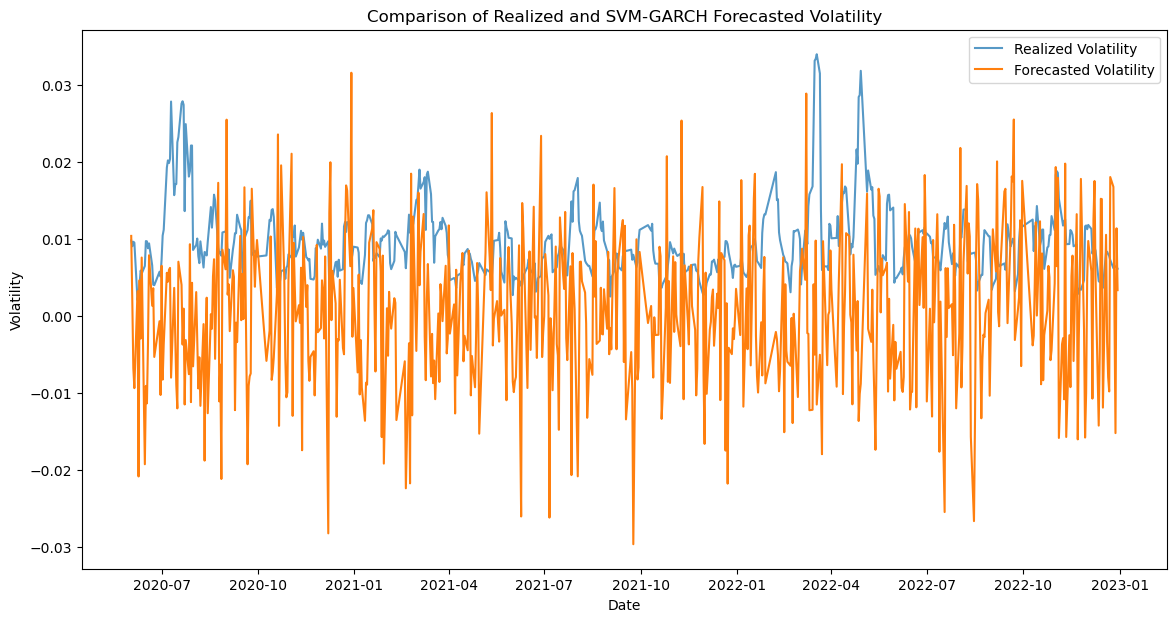

In [19]:
forecast_svm = svmgarch_result.forecast()
# For the GARCH forecasted volatility
# Assuming the svmgarch_result contains the GARCH model fitted with SVM predicted volatility
forecasted_volatility = svmgarch_result.conditional_volatility

daily_returns = SSE['Adj Close'].pct_change()

# Calculating realized volatility as the rolling standard deviation of daily returns
# Here, we're using a 30-day rolling window, but you can adjust this
realized_volatility = daily_returns.rolling(window=5).std()

# Now let's get the last 20% of the data for plotting
split_index = int(len(SSE) * 0.8)
test_dates = SSE.index[split_index:]
realized_volatility_test = realized_volatility[split_index:]

# Here you should replace forecasted_volatility with your actual forecasted data
# For the sake of this example, we're generating sample data
forecasted_volatility = np.random.randn(len(test_dates)) * 0.01  # Example data

# Ensure forecasted_volatility aligns in length with your test segment
assert len(forecasted_volatility) == len(realized_volatility_test)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_dates, realized_volatility_test, label='Realized Volatility', alpha=0.75)
plt.plot(test_dates, forecasted_volatility, label='Forecasted Volatility')
plt.legend()
plt.title('Comparison of Realized and SVM-GARCH Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

n = 180
para_grid = {'gamma': sp_rand(),
             'C': sp_rand(),
             'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values,
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = returns.iloc[-n:].index

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

iid_kde = gaussian_kde(train)
iid_kde_samp = iid_kde.resample((50000*len(test))).reshape(50000,len(test))
am = arch_model(train, p=1,q=1)
res = am.fit(update_freq=5)
garch_samples_matrix = res.forecast(horizon=len(test), simulations = 50000, reindex=False, method = "simulation").simulations.values[0,:,:]
benchmark_lpdfs = [iid_kde.logpdf(test[i])[0] for i in range(len(test))]
garch_lpdfs = [gaussian_kde(garch_samples_matrix[:,i]).logpdf(test[i])[0] for i in range(len(test))]
forest_samples_matrix = np.concatenate(forest_samples,1)
forest_std = np.std(forest_samples_matrix,0)
forest_lower = np.quantile(forest_samples_matrix,0.05,0)
forest_upper = np.quantile(forest_samples_matrix,0.95,0)
forest_lpdfs = [gaussian_kde(forest_samples_matrix[:,i]).logpdf(test[i])[0] for i in range(len(test))]
forest_samples = []
for t in range(len(test)):
    pred = forest_model.predict(Xt.values).reshape(-1,1)
    samp = norm(0, 1).rvs(samp_size).reshape(-1,1)*np.sqrt(pred)
    forest_samples.append(samp)
    Xt = pd.DataFrame(np.concatenate([np.array(samp).reshape(-1,1),Xt.values[:,:-1]],1))
    Xt.columns = X_train.columns   
forest_samples_matrix = np.concatenate(forest_samples,1)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(19,18))
st = fig.suptitle("Symbol: "+symbol, fontsize=20)

ax1.plot(train.iloc[-50:], color = "blue", label = "Last 50 observations of training set")
ax1.plot(test, color = "red", label = "Test set")
ax1.grid(alpha = 0.5)
ax1.margins(x=0)
ax1.fill_between(test.index, forest_lower, forest_upper, color="orange", alpha=0.5, label="Random Forest ARCH - 90% forecast interval")
ax1.legend()
ax1.set_title("Random Forest ARCH - Test set loglikelihood: {}".format(str(np.sum(forest_lpdfs))[:7]), fontdict={'fontsize': 15})

ax2.plot(train.iloc[-50:], color = "blue", label = "Last 50 observations of training set")
ax2.plot(test, color = "red", label = "Test set")
ax2.grid(alpha = 0.5)
ax2.margins(x=0)
ax2.fill_between(test.index, garch_lower, garch_upper, color="orange", alpha=0.5, label="GARCH (5,5) - 90% forecast interval")
ax2.legend()
ax2.set_title("GARCH(5,5)- Test set loglikelihood: {}".format(str(np.sum(garch_lpdfs))[:7]), fontdict={'fontsize': 15})
